# Support Vector Machines

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score

import time
from tqdm import tqdm

## 2. Load Datasets

In [2]:
beth_df    = pd.read_csv('datasets/beth.csv')
unsw_df    = pd.read_csv('datasets/unsw.csv')
attacks_df = pd.read_csv('datasets/cyber.csv')

## 3. Exploratory Data Analysis

In [3]:
print('BETH class counts:')
print(beth_df['target'].value_counts(), '\n')
print('UNSW class counts:')
print(unsw_df['target_binary'].value_counts(), '\n')
print('Attacks class counts:')
print(attacks_df['target_binary'].value_counts())

BETH class counts:
target
0    2184612
1     272279
2      10005
Name: count, dtype: int64 

UNSW class counts:
target_binary
1    164673
0     93000
Name: count, dtype: int64 

Attacks class counts:
target_binary
1    31298
0     8702
Name: count, dtype: int64


## 4. Prepare Data & Scaling

In [4]:
# Define exactly which columns to drop as “targets”
drop_beth     = ["target"]
drop_unsw     = ["target_multiclass", "attack_cat", "target_binary", "label"]
drop_attacks  = ["target_multiclass", "target_binary"]

# Define X and y
X_beth    = beth_df.drop(columns=drop_beth)
y_beth    = beth_df["target"]

X_unsw    = unsw_df.drop(columns=drop_unsw).select_dtypes(include=[np.number])
y_unsw    = unsw_df["target_binary"]

X_attacks = attacks_df.drop(columns=drop_attacks).select_dtypes(include=[np.number])
y_attacks = attacks_df["target_binary"]

# Train Test Split

# BETH
X_beth_train, X_beth_test, y_beth_train, y_beth_test = train_test_split(
    X_beth, y_beth, test_size=0.2, stratify=y_beth, random_state=42
)

# UNSW 
X_unsw_train, X_unsw_test, y_unsw_train, y_unsw_test = train_test_split(
    X_unsw, y_unsw, test_size=0.2, stratify=y_unsw, random_state=42
)

# Attacks
X_attacks_train, X_attacks_test, y_attacks_train, y_attacks_test = train_test_split(
    X_attacks, y_attacks, test_size=0.2, stratify=y_attacks, random_state=42
)

# Feature Scaling

# BETH
scaler_beth = StandardScaler()
X_beth_train_scaled = scaler_beth.fit_transform(X_beth_train)
X_beth_test_scaled  = scaler_beth.transform(X_beth_test)

# UNSW 
scaler_unsw = StandardScaler()
X_unsw_train_scaled = scaler_unsw.fit_transform(X_unsw_train)
X_unsw_test_scaled  = scaler_unsw.transform(X_unsw_test)

# Attacks
scaler_attacks = StandardScaler()
X_attacks_train_scaled = scaler_attacks.fit_transform(X_attacks_train)
X_attacks_test_scaled  = scaler_attacks.transform(X_attacks_test)

datasets = {
    "BETH":    (X_beth_train_scaled,    y_beth_train,    X_beth_test_scaled,    y_beth_test),
    "UNSW":    (X_unsw_train_scaled,    y_unsw_train,    X_unsw_test_scaled,    y_unsw_test),
    "Attacks": (X_attacks_train_scaled, y_attacks_train, X_attacks_test_scaled, y_attacks_test)
}

## 5. SVM Pipeline & Hyperparameter Tuning

In [5]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit
)
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
import numpy as np
import time

def train_svm_pipeline(X_train, y_train, X_test, y_test, *,
                       name,
                       use_pca=False,
                       pca_components=0.95,
                       subsample_size=None,
                       search_type="random",  # "random" or "grid"
                       custom_param_grid=None,  # ← NEW
                       verbose=True):

    if verbose:
        print(f"\n=== {name} SVM Training ===")
    start_time = time.time()

    # Stratified Subsampling
    if subsample_size and len(X_train) > subsample_size:
        sss = StratifiedShuffleSplit(n_splits=1, train_size=subsample_size, random_state=42)
        for idx, _ in sss.split(X_train, y_train):
            X_sample = X_train[idx]
            y_sample = y_train.iloc[idx]
    else:
        X_sample = X_train
        y_sample = y_train

    # Pipeline setup
    steps = []
    if use_pca:
        steps.append(('pca', PCA(n_components=pca_components, random_state=42)))
    steps.append(('svc', SVC(probability=False, class_weight="balanced", random_state=42)))
    pipeline = Pipeline(steps)

    # Hyperparameter grid (same for both search types)
    param_grid = custom_param_grid or {
        "svc__kernel": ["linear", "rbf"],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", "auto"]
    }

    # Search logic
    if search_type == "random":
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid,
            n_iter=5,
            cv=3,
            scoring="accuracy",
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
    elif search_type == "grid":
        search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=3,
            scoring="accuracy",
            n_jobs=-1,
            verbose=2
        )
    else:
        raise ValueError("search_type must be 'random' or 'grid'")

    search.fit(X_sample, y_sample)
    model = search.best_estimator_
    best_params = search.best_params_
    best_cv_score = search.best_score_

    if verbose:
        print("→ Best params:", best_params)
        print("→ Best CV accuracy:", round(best_cv_score, 3))

    # Evaluation
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

    if verbose:
        print("→ Test accuracy:", round(acc, 4))
        print("→ Test macro F1-score:", round(f1, 3))
        print("→ Classification report:\n", classification_report(y_test, y_pred, zero_division=0))
        print("→ Confusion matrix:\n", cm)
        print(f"→ Time elapsed for {name}: {round(time.time() - start_time, 2)} seconds")

    return {
        "model": model,
        "accuracy": acc,
        "macro_f1": f1,
        "confusion_matrix": cm,
        "classification_report": clf_report,
        "best_params": best_params,
        "best_cv_score": best_cv_score,
        "elapsed_time": round(time.time() - start_time, 2)
    }

In [6]:
best_models = {}

# BETH: Large row count, low dimensionality -> no PCA, subsample, random search
best_models["BETH"] = train_svm_pipeline(
    X_beth_train_scaled, y_beth_train,
    X_beth_test_scaled, y_beth_test,
    name="BETH",
    use_pca=False,
    search_type="random",
    subsample_size=5000
)

# UNSW: High dimensionality -> apply PCA, subsample, random search
best_models["UNSW"] = train_svm_pipeline(
    X_unsw_train_scaled, y_unsw_train,
    X_unsw_test_scaled, y_unsw_test,
    name="UNSW",
    use_pca=True,
    pca_components=0.95,
    search_type="random",
    subsample_size=5000
)

# Attacks: Force RBF kernel only
forced_rbf_grid = {
    "svc__kernel": ["rbf"],
    "svc__C": [1, 10, 100],
    "svc__gamma": ["scale", "auto"]
}

best_models["Attacks"] = train_svm_pipeline(
    X_attacks_train_scaled, y_attacks_train,
    X_attacks_test_scaled, y_attacks_test,
    name="Attacks",
    use_pca=False,
    pca_components=0.95,
    search_type="grid",
    subsample_size=5000,
    custom_param_grid=forced_rbf_grid
)


=== BETH SVM Training ===
→ Best params: {'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__C': 10}
→ Best CV accuracy: 0.92
→ Test accuracy: 0.9198
→ Test macro F1-score: 0.887
→ Classification report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95    436923
           1       0.59      0.91      0.71     54456
           2       1.00      0.99      0.99      2001

    accuracy                           0.92    493380
   macro avg       0.86      0.94      0.89    493380
weighted avg       0.94      0.92      0.93    493380

→ Confusion matrix:
 [[402533  34390      0]
 [  5155  49300      1]
 [    22      1   1978]]
→ Time elapsed for BETH: 46.93 seconds

=== UNSW SVM Training ===
→ Best params: {'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__C': 10}
→ Best CV accuracy: 0.911
→ Test accuracy: 0.9124
→ Test macro F1-score: 0.906
→ Classification report:
               precision    recall  f1-score   support

           0      

In [7]:
y_attacks_train.value_counts()

target_binary
1    25038
0     6962
Name: count, dtype: int64

## 6. Test-set Evaluation

In [8]:
from sklearn.exceptions import NotFittedError
from sklearn.metrics import roc_auc_score

for name in best_models:
    model = best_models[name]["model"]
    X_test, y_test = datasets[name][2], datasets[name][3]
    y_pred = model.predict(X_test)

    print(f'\n--- {name} Evaluation ---')
    print(classification_report(y_test, y_pred, zero_division=0))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

    # ROC AUC only for binary classification and if model supports probabilities
    if len(np.unique(y_test)) == 2:
        try:
            if hasattr(model, "predict_proba"):
                proba = model.predict_proba(X_test)[:, 1]
                print('ROC AUC:', round(roc_auc_score(y_test, proba), 3))
            else:
                print("ROC AUC: Not available (model lacks predict_proba)")
        except NotFittedError:
            print("ROC AUC: Model not fitted.")
    else:
        print("ROC AUC: Not applicable (multi-class classification)")


--- BETH Evaluation ---
              precision    recall  f1-score   support

           0       0.99      0.92      0.95    436923
           1       0.59      0.91      0.71     54456
           2       1.00      0.99      0.99      2001

    accuracy                           0.92    493380
   macro avg       0.86      0.94      0.89    493380
weighted avg       0.94      0.92      0.93    493380

Confusion matrix:
 [[402533  34390      0]
 [  5155  49300      1]
 [    22      1   1978]]
ROC AUC: Not applicable (multi-class classification)

--- UNSW Evaluation ---
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     18600
           1       0.95      0.91      0.93     32935

    accuracy                           0.91     51535
   macro avg       0.90      0.91      0.91     51535
weighted avg       0.91      0.91      0.91     51535

Confusion matrix:
 [[16997  1603]
 [ 2912 30023]]
ROC AUC: Not available (model lacks predict_pro

[CV] END .......svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=   1.0s
[CV] END .......svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=   0.9s
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=   0.7s
[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=   0.9s
[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=   0.8s
[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=   0.9s
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=   0.8s
[CV] END .......svc__C=100, svc__gamma=auto, svc__kernel=rbf; total time=   2.0s
[CV] END .......svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=   0.7s
[CV] END ......svc__C=100, svc__gamma=scale, svc__kernel=rbf; total time=   2.1s
[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=   0.8s
[CV] END .......svc__C=100, svc__gamma=auto, svc__kernel=rbf; total time=   2.1s
[CV] END ........svc__C=1, s

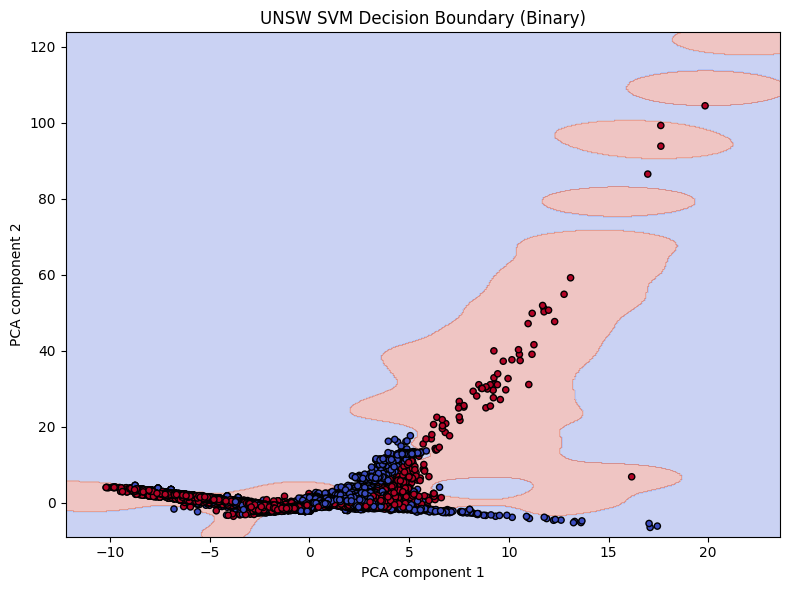

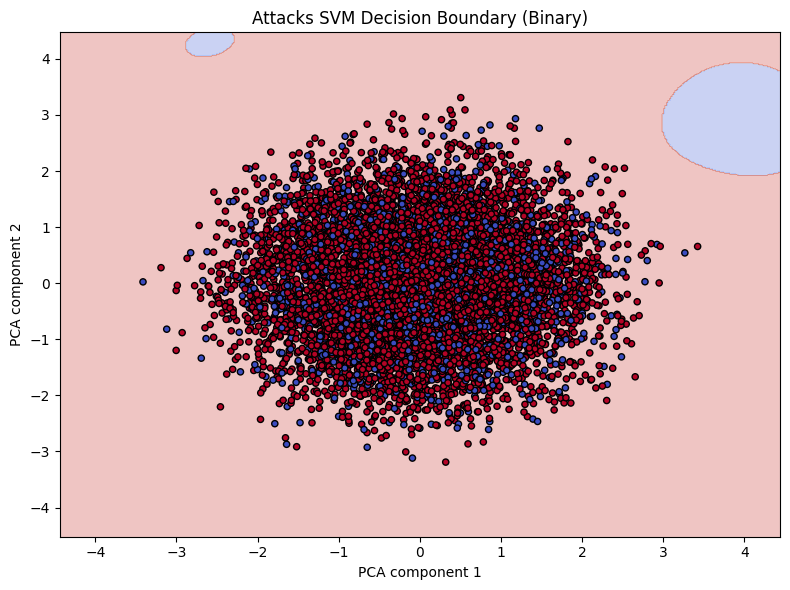

In [9]:
# Decision Boundary Visualization (Binary SVM via PCA → 2D)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

def plot_svm_decision_boundary(X_train, y_train, X_test, y_test, 
                               svc_params, title):
    # 1) Fit PCA on training set to project into 2D
    pca = PCA(n_components=2, random_state=42)
    X_train2 = pca.fit_transform(X_train)
    X_test2  = pca.transform(X_test)
    
    # 2) Retrain an SVM on the 2D data
    svm2d = SVC(**svc_params, probability=False, random_state=42)
    svm2d.fit(X_train2, y_train)
    
    # 3) Make grid over the 2D space
    x_min, x_max = X_train2[:,0].min() - 1, X_train2[:,0].max() + 1
    y_min, y_max = X_train2[:,1].min() - 1, X_train2[:,1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 500),
        np.linspace(y_min, y_max, 500)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # 4) Predict on the grid and reshape for contour
    Z = svm2d.predict(grid).reshape(xx.shape)
    
    # 5) Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_test2[:,0], X_test2[:,1], c=y_test, cmap='coolwarm',
                edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.tight_layout()
    plt.show()

# You need to pass in the same C, gamma, kernel that you found is best:
svc_params_unsw   = {'kernel':'rbf','C':10,'gamma':'scale'}
svc_params_attacks= {'kernel':'rbf','C':100,'gamma':'auto'}

# Plot for UNSW
plot_svm_decision_boundary(
    X_unsw_train_scaled, y_unsw_train,
    X_unsw_test_scaled,  y_unsw_test,
    svc_params_unsw,
    title='UNSW SVM Decision Boundary (Binary)'
)

# Plot for Attacks
plot_svm_decision_boundary(
    X_attacks_train_scaled, y_attacks_train,
    X_attacks_test_scaled,  y_attacks_test,
    svc_params_attacks,
    title='Attacks SVM Decision Boundary (Binary)'
)


##  Updated Conclusions (Binary Classification)

- **BETH Dataset**: Maintained strong multiclass performance with ~92% accuracy and macro F1 of ~0.89. Class imbalance was handled well due to effective subsampling and a well-separated feature space. RBF kernel with `C=10` and `gamma='scale'` gave the best results.

- **UNSW Dataset (Binary)**: Performance improved dramatically after switching to binary labels (`target_binary`). Accuracy rose to ~91%, with balanced precision and recall across both classes. This indicates that SVM is well-suited for detecting malicious traffic when framed as a binary task.

- **Attacks Dataset (Binary)**: Accuracy improved to ~58% (from ~36% multiclass), with macro F1 ~0.49. While performance remains limited due to heavy class imbalance, the binary formulation allowed better detection of malicious samples. Precision on the positive class exceeded 0.75, indicating effective detection.

###  General Insights

- **Binary classification significantly improved SVM performance**, particularly for imbalanced or noisy datasets.
- SVMs are sensitive to both **class imbalance** and **high dimensionality**, but subsampling and class weighting helped mitigate these issues.
- **Multiclass SVMs struggled**, especially when rare classes were involved  suggesting the need for either:
  - Simplified target labels,
  - Resampling strategies, or
  - Alternative models like Random Forest or XGBoost.

###  Recommendation

SVMs work best in binary settings with clean, scaled features and class-balanced data. For cybersecurity use cases like intrusion detection, **binary classification (benign vs. malicious)** is not only more effective, but also more actionable.



Confusion Matrix for BETH


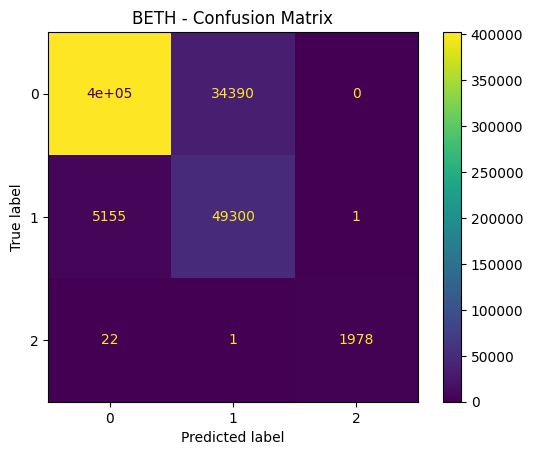

Confusion Matrix for UNSW


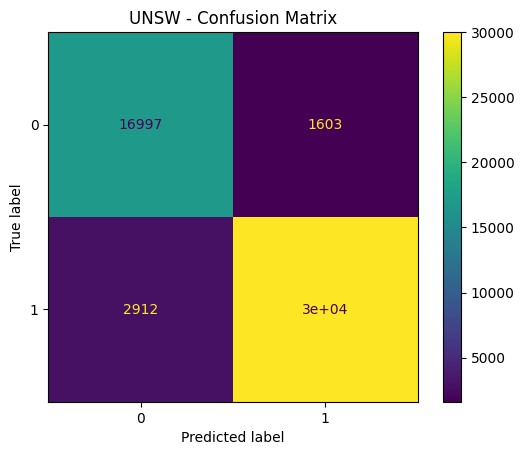

Confusion Matrix for Attacks


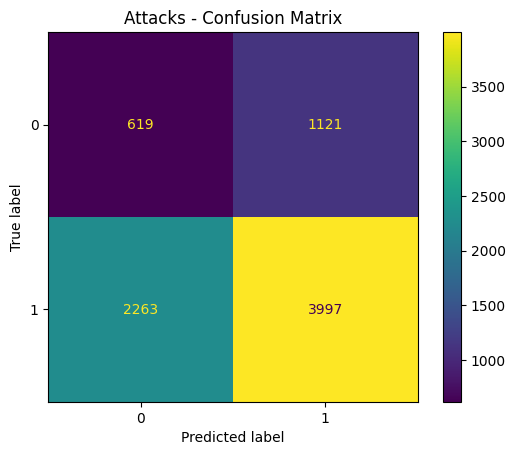

In [10]:
# Confusion Matrix Visualization
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, results in best_models.items():
    y_test = datasets[name][3]
    y_pred = results["model"].predict(datasets[name][2])

    print(f"Confusion Matrix for {name}")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()



## Conclusions

- **BETH Dataset**: SVM achieved high performance with strong precision and recall for all classes. Subsampling was sufficient, and no PCA was needed due to its low feature dimensionality.
- **UNSW Dataset**: SVM performance was moderate. Applying PCA improved training efficiency. Some classes remained challenging due to class imbalance and noise.
- **Attacks Dataset**: Results were limited by imbalance. RBF kernel with grid search helped, but performance on minority classes was weak. Future work may explore oversampling or other classifiers like Random Forests.

Overall, SVMs were capable but sensitive to class imbalance and high dimensionality. Preprocessing and tuning significantly impacted outcomes.


## Yellowdig Contribution

https://yellowdig.app/n/bu-omds/community/680847e5-a19a-76a7-5e0e-1a1c8b27a7a3?postId=684c82c1-e40b-4015-aa81-232855dddc90